<a href="https://colab.research.google.com/github/jyjoon001/EEE4171/blob/main/aicomm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt

In [ ]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_class = 10
# hyper - parameters
num_epochs = 5
learning_rate = 0.0025
batch_size = 128
max_pool_kernel = 2

In [ ]:
train_data = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_data = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

In [ ]:
!nvidia-smi

Sat Apr 24 11:51:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   1542MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Define DataLoader
train_loader = torch.utils.data.DataLoader(train_data,
                                     batch_size=batch_size,
                                     shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                     batch_size=batch_size,
                                     shuffle=False)

In [ ]:
def image_show(dataset, num):
  fig = plt.figure(figsize=(30,30))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i][0].squeeze())
    plt.title(dataset[i][1])

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, num_class):
    super(ConvNet, self).__init__()
    self.layer1a = nn.Sequential(
        nn.Conv2d(1, 10, 3, stride=1, padding=1),
        nn.BatchNorm2d(10),
        nn.ReLU()
    )
    self.layer1b = nn.Sequential(
        nn.Conv2d(10, 16, 3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    self.layer2a = nn.Sequential(
        nn.LeakyReLU(),
        nn.Conv2d(16, 16, 3, stride=1, padding=1),
        nn.BatchNorm2d(16)
    )
    self.layer2b = nn.Sequential(
        nn.LeakyReLU(),
        nn.Conv2d(16, 16, 3, stride=1, padding=1),
        nn.BatchNorm2d(16)
    )
    self.layer2c = nn.Sequential(
        nn.Conv2d(16, 32, 5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )
    self.layer3a = nn.Sequential(
        nn.Conv2d(32, 64, 7, stride=1, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer3b = nn.Sequential(
        nn.Conv2d(64, 128, 7, stride=1, padding=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(6),
        nn.Flatten()
    )
    self.fc0 = nn.Sequential(
        nn.Linear(6*6*128, 360),
        nn.BatchNorm1d(360),
        nn.ReLU()
    )
    self.fc1 = nn.Sequential(
        nn.Linear(360, 120),
        nn.BatchNorm1d(120),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(120, 84),
        nn.BatchNorm1d(84),
        nn.ReLU()
    )
    self.fc3 = nn.Sequential(
        nn.Linear(84, num_class),
        nn.BatchNorm1d(num_class)
    )
    self.maxpool = nn.MaxPool2d(max_pool_kernel)

  def forward(self, x):
    x = self.layer1a(x)
    x = self.layer1b(x)
    res = x

    x = self.layer2a(x)
    x = self.layer2b(x)
    x = self.maxpool(x+res)
    x = self.layer2c(x)

    x = self.layer3a(x)   
    x = self.layer3b(x)   
    x = x.reshape(x.size(0),-1)
    x = self.fc0(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = F.log_softmax(self.fc3(x))
    return x

model = ConvNet(num_class).to(device)

In [ ]:
model

ConvNet(
  (layer1a): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1b): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2a): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2b): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2c): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1):

In [ ]:
# Set Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
import time

In [ ]:
image, label = next(iter(test_loader))
print(image.size()) # [Batch, Channel, Height, Width]

torch.Size([128, 1, 28, 28])


In [ ]:
start = time.time()
best_epoch = 0
best_loss = float('inf')
total_step = len(train_loader)
loss_list = []

for epoch in range(num_epochs):
  for i, (image, label) in enumerate(train_loader):
    image = image.to(device)
    label = label.to(device)

    # Forward
    output = model(image)
    loss = criterion(output, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

    if (i+1) % 1000 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))

end = time.time()
print("Train takes {:.2f}minutes".format((end-start)/60))
torch.save(model.state_dict(),'20161482_model2.pth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train takes 1.40minutes


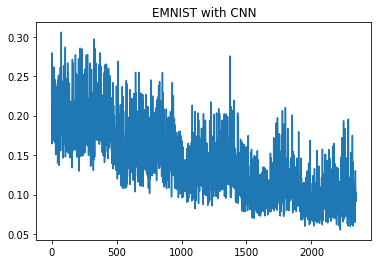

In [ ]:
plt.plot(loss_list)
plt.title("EMNIST with CNN")
plt.show()

In [ ]:
model_saved = ConvNet(num_class).to(device)
model_saved.load_state_dict(torch.load("20161482_model2.pth"))
model_saved.eval()

with torch.no_grad():
  correct = 0
  
  for img, lab in test_loader:
    img = img.to(device)
    lab = lab.to(device)
    out = model_saved(img)
    _, pred = torch.max(out.data, 1)
    correct += (pred == lab).sum().item()

  print("Accuracy of the network on the {} test images: {}%".format(len(test_loader)*batch_size, 100 * correct / (len(test_loader) * batch_size)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10112 test images: 91.0304588607595%
